#Problem Statement
Using the baseball dataset, build a logistic regression model that predicts who 
is likely to be inducted into Hall of Fame. Start with considering as many 
explanatory variables. What factors are signficant?  Reduce your explanatory 
variables to the ones that are significant. Compare performance between having 
many variables vs having a smaller set. Cross validate your model and print 
out the coeffecients of the best model. Considering any two features, generate 
a scatter plot with a class separable line showing the classification.

#Import Packages

In [76]:
import sqlite3 as sq
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
from sklearn.cross_validation import cross_val_score as cv
from sklearn.grid_search import GridSearchCV as gscv
from sklearn.feature_selection import RFECV as rfe
from sklearn import linear_model as lm
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
from patsy import dmatrix, dmatrices
import matplotlib.pylab as plt
from pylab import rcParams

In [77]:
%matplotlib inline

#Load user defined cleaning functions

In [78]:
#convert low-freq categorical feature values to 'Other'
def cleanup_data(df, cutoffPercent = .01):
    for col in df:
        sizes = df[col].value_counts(normalize = True)
        values_to_delete = sizes[sizes<cutoffPercent].index
        df[col].ix[df[col].isin(values_to_delete)] = "Other"
    return df

#binazrize catergoical feature values into individual variables
def get_binary_values(data_frame):
    """encodes categorical features in Pandas."""
    all_columns = pd.DataFrame(index = data_frame.index)
    for col in data_frame.columns:
        data = pd.get_dummies(data_frame[col], prefix=col.encode('ascii', 'replace'))
        all_columns = pd.concat([all_columns, data], axis=1)
    return all_columns

#find and remove variables with zero variance
def find_zero_var(df):
    """finds columns in the dataframe with zero variance -- ie those
        with the same value in every observation.
    """
    toKeep = []
    toDelete = []
    for col in df:
      if len(df[col].value_counts()) > 1:
         toKeep.append(col)
      else:
        toDelete.append(col)      
    return {'toKeep':toKeep, 'toDelete':toDelete}
    
#find and remove variables with perfect correlation
def find_perfect_corr(df):
    """finds columns that are eother positively or negatively perfectly 
        correlated (with correlations of +1 or -1), and creates a dict that 
        includes which columns to drop so that each remaining column is independent
    """
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] = np.tril(corrMatrix.values, k = -1)
    already_in = set()
    result = []
    for col in corrMatrix:
        perfect_corr = corrMatrix[col][abs(np.round(corrMatrix[col],10)) == 1.00].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    toRemove = []
    for item in result:
        toRemove.append(item[1:(len(item)+1)])
        toRemove = sum(toRemove, [])
    return {'corrGroupings':result, 'toRemove':toRemove}

#Get Data From SQL DB into Pandas Data Frame
The following variables are pulled from the lahman2013 database:<br>
Batting - at bats, runs, hits, home runs, strikeouts, <br>
Pitching - wins, losses, shutouts, saves, earned runs, strikeouts<br>
Fielding - puts, double plays<br>

In [87]:
#connect to SQLite DB
conn = sq.connect('lahman2013.sqlite')

#get position, dominant team and performance stats
query2 = """select h.*, 
  b.b_atbat, b.b_runs, b.b_hits, b.b_hruns, b.b_stbas, b.b_strik,
  p.p_wins, p.p_loss, p.p_shout, p.p_saves, p.p_eruns, p.p_stout, 
  f.f_puts, f.f_assis, f.f_dplay, f.f_pass, t.teamid
from 
  (select playerid, max(case when inducted = 'Y' then 1 else 0 end) as inducted, max(yearid) as year
   from halloffame where category = 'Player' group by playerid) h
left outer join 
  (select playerid, sum(ab) as b_atbat, sum(r) as b_runs, sum(h) as b_hits, 
    sum(hr) as b_hruns, sum(sb) as b_stbas, sum(so) as b_strik
  from batting group by playerid) b on h.playerid = b.playerid
left outer join
  (select playerid, sum(w) as p_wins, sum(l) as p_loss, sum(sho) as p_shout,
    sum(sv) as p_saves, sum(er) as p_eruns, sum(so) as p_stout
  from pitching group by playerid) p on h.playerid = p.playerid
left outer join
  (select playerid, sum(po) as f_puts, sum(a) as f_assis, sum(dp) as f_dplay, sum(pb) as f_pass 
  from fielding group by playerid) f on h.playerid = f.playerid
left outer join
  (select * from dominant_team_per_player) t on h.playerid = t.playerid
;"""

df = pd.read_sql(query2, conn)

#close connection
conn.close()

In [88]:
#check data
df.head()

,playerid,inducted,year,b_atbat,b_runs,b_hits,b_hruns,b_stbas,b_strik,p_wins,p_loss,p_shout,p_saves,p_eruns,p_stout,f_puts,f_assis,f_dplay,f_pass,teamID
0,aaronha01,1,1982,12364,2174,3771,755,240,1383,NaN,NaN,NaN,NaN,NaN,NaN,12926,647,258,NaN,ML1
1,abbotji01,0,2005,21,0,2,0,0,10,87,108,6,0,791,888,72,300,16,NaN,CAL
2,adamsba01,0,1955,1019,79,216,3,1,177,194,140,44,15,917,1036,58,648,17,NaN,PIT
3,adamsbo03,0,1966,4019,591,1082,37,67,447,NaN,NaN,NaN,NaN,NaN,NaN,1748,2262,371,NaN,CIN
4,adamssp01,0,1960,5557,844,1588,9,154,223,NaN,NaN,NaN,NaN,NaN,NaN,2287,3748,597,NaN,CHN


In [89]:
df.tail()

,playerid,inducted,year,b_atbat,b_runs,b_hits,b_hruns,b_stbas,b_strik,p_wins,p_loss,p_shout,p_saves,p_eruns,p_stout,f_puts,f_assis,f_dplay,f_pass,teamID
1152,zachrpa01,0,1991,318,9,36,0,0,128,69,67,7,3,461,669,60,176,19,NaN,NYN
1153,zahnge01,0,1991,43,3,6,0,0,9,111,109,20,1,769,705,87,326,19,NaN,CAL
1154,zeileto01,0,2010,7573,986,2004,253,53,1279,0,0,0,0,5,1,5256,3088,552,15,SLN
1155,zimmech01,0,1938,4546,617,1224,26,151,323,NaN,NaN,NaN,NaN,NaN,NaN,5121,1594,145,355,CL4
1156,ziskri01,0,1989,5144,681,1477,207,8,910,NaN,NaN,NaN,NaN,NaN,NaN,3365,137,41,NaN,PIT


In [90]:
df.shape

(1157, 20)

The data is split into two sets: one before year 2000 for training and the other 
on/after 2000 for future predictions. From both sets, records with 
all missing variables are removed. Then the categorical features are binned and binarized, 
numeric missings are imputed with 0, and all variabless are scaled -- separately for the 
two datasets.

In [91]:
#split data before and on/after year 2000 (training vs future predictions)
pre2000 = df[df.year < 2000.00]
post2000 = df[df.year >= 2000.00]

#Transform Data for Training (< 2000)

In [92]:
#drop records where all explanatory variables are missing (13 dropped)
pre2000.dropna(thresh=4,inplace=True)
pre2000.shape #882 players

/Users/tdong/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


(882, 20)

In [93]:
#split dataset into id, explanatory and response features
exp = [col for col in pre2000.columns if col not in ['playerid','inducted','year']]
pre2000_exp = pre2000[exp]
pre2000_res = pre2000.inducted

#split explanatory features into categorical vs numeric
catfeat = pre2000_exp.ix[:, pre2000_exp.dtypes == 'object']
numfeat= pre2000_exp.ix[:, pre2000_exp.dtypes != 'object']

#fill cat NaNs with 'None'
catfeat = catfeat.fillna('None')

#bin and binarize cat vars
cleanup_data(catfeat, cutoffPercent = .01)
catfeat_bin = get_binary_values(catfeat)

In [94]:
# fill NANs in nuemeric features with zero
numfeat.fillna(0, inplace=True)

# Merge categorical and numeric dataframes
pre2000_exp = pd.concat([numfeat, catfeat_bin],axis = 1)

# find features with no variance (NONE / KEEP ALL)
find_zero_var(pre2000_exp)

/Users/tdong/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


{'toDelete': [],
 'toKeep': ['b_atbat',
  'b_runs',
  'b_hits',
  'b_hruns',
  'b_stbas',
  'b_strik',
  'p_wins',
  'p_loss',
  'p_shout',
  'p_saves',
  'p_eruns',
  'p_stout',
  'f_puts',
  'f_assis',
  'f_dplay',
  'f_pass',
  u'teamID_BAL',
  u'teamID_BOS',
  u'teamID_BRO',
  u'teamID_BSN',
  u'teamID_CAL',
  u'teamID_CHA',
  u'teamID_CHN',
  u'teamID_CIN',
  u'teamID_CLE',
  u'teamID_DET',
  u'teamID_HOU',
  u'teamID_KCA',
  u'teamID_LAN',
  u'teamID_MIN',
  u'teamID_ML4',
  u'teamID_MON',
  u'teamID_NY1',
  u'teamID_NYA',
  u'teamID_NYN',
  u'teamID_OAK',
  'teamID_Other',
  u'teamID_PHA',
  u'teamID_PHI',
  u'teamID_PIT',
  u'teamID_SFN',
  u'teamID_SLA',
  u'teamID_SLN',
  u'teamID_WS1']}

In [95]:
#find features with perfect correlation (NONE / KEEP ALL)
find_perfect_corr(pre2000_exp)

{'corrGroupings': [], 'toRemove': []}

In [16]:
#scale features
scaler = pp.StandardScaler()
scaler.fit(pre2000_exp)
pre2000_exp_scaled = pd.DataFrame(scaler.transform(pre2000_exp), 
                                  index = pre2000_exp.index, 
                                  columns = pre2000_exp.columns)

#retain unscaled features
pre2000_exp = pd.concat([numfeat, catfeat_bin],axis = 1)
find_zero_var(pre2000_exp)

{'toDelete': [],
 'toKeep': ['b_atbat',
  'b_runs',
  'b_hits',
  'b_hruns',
  'b_stbas',
  'b_strik',
  'p_wins',
  'p_loss',
  'p_shout',
  'p_saves',
  'p_eruns',
  'p_stout',
  'f_puts',
  'f_assis',
  'f_dplay',
  'f_pass',
  u'teamID_BAL',
  u'teamID_BOS',
  u'teamID_BRO',
  u'teamID_BSN',
  u'teamID_CAL',
  u'teamID_CHA',
  u'teamID_CHN',
  u'teamID_CIN',
  u'teamID_CLE',
  u'teamID_DET',
  u'teamID_HOU',
  u'teamID_KCA',
  u'teamID_LAN',
  u'teamID_MIN',
  u'teamID_ML4',
  u'teamID_MON',
  u'teamID_NY1',
  u'teamID_NYA',
  u'teamID_NYN',
  u'teamID_OAK',
  'teamID_Other',
  u'teamID_PHA',
  u'teamID_PHI',
  u'teamID_PIT',
  u'teamID_SFN',
  u'teamID_SLA',
  u'teamID_SLN',
  u'teamID_WS1']}

In [17]:
find_perfect_corr(pre2000_exp)

{'corrGroupings': [], 'toRemove': []}

#Transform Data For Future Predictions (>= 2000)

In [18]:
#drop records where all explanatory variables are missing (14 dropped)
post2000.dropna(thresh=4,inplace=True)
post2000.shape
#248 players

/Users/tdong/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(248, 20)

In [19]:
#split dataset into id, explanatory and response features
post2000_exp = post2000[exp]
post2000_res = post2000.inducted

#split explanatory features into categorical vs numeric
catfeat_post = post2000_exp.ix[:, post2000_exp.dtypes == 'object']
numfeat_post= post2000_exp.ix[:, post2000_exp.dtypes != 'object']

#fill categorical missings with 'None'
catfeat_post.fillna('None', inplace=True)

#replace low-frequency categorical values with 'Other' using
#same breaks as training data
catfeat_post.teamID[~catfeat_post.teamID.isin(team_list)] = 'Other'

#binarize categorical feature values into individual variables
catfeat_post_bin = get_binary_values(catfeat_post)

#identify binarized variables in training set that are not in future
#prediction set and add these columns (all set to 0) in future set
missing_col = catfeat_bin.columns[~catfeat_bin.columns.isin(catfeat_post_bin.columns)]
for c in missing_col:
    catfeat_post_bin[c] = 0
catfeat_post_bin = catfeat_post_bin[catfeat_bin.columns]

#impute numerical missings with 0
numfeat_post.fillna(0, inplace=True)

#merge categorical and numeric features
post2000_exp = pd.concat([numfeat_post, catfeat_post_bin],axis = 1)

#make sure final columns and their order are identical to training set
post2000_exp = post2000_exp[pre2000_exp.columns]

#scale data
scaler = pp.StandardScaler()
scaler.fit(post2000_exp)
post2000_exp_scaled = pd.DataFrame(scaler.transform(post2000_exp), 
                                   index = post2000_exp.index, 
                                   columns = post2000_exp.columns)
                                   
#retain unscaled features
post2000_exp = pd.concat([numfeat_post, catfeat_post_bin],axis = 1)
post2000_exp = post2000_exp[pre2000_exp.columns]

/Users/tdong/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tdong/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3394: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/tdong/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tdong

An initial recursive feature search with logistic regression and 10-fold 
cross-validation on the training set suggests that 31 of the 44 features are important.  
The mean ROC AUC from cross-validation is 94.3%.

In [20]:
#IDENTIFY POTENTIAL FEATURES WITH RECURSIVE FEATURE SEARCH AND 10-FOLD CV------

#run recursive feature search with 10-fold cv to identify potential features
lr = lm.LogisticRegression()
lr_rfe_cv = rfe(estimator=lr, step=1, cv=10, scoring='roc_auc', verbose = 1)
lr_rfe_cv.fit(pre2000_exp_scaled, pre2000_res)

#identify features
features = pre2000_exp_scaled.columns[lr_rfe_cv.get_support()]
print features

Finished fold with 1 / 44 feature ranks, score=0.874436
Finished fold with 2 / 44 feature ranks, score=0.924060
Finished fold with 3 / 44 feature ranks, score=0.924060
Finished fold with 4 / 44 feature ranks, score=0.931579
Finished fold with 5 / 44 feature ranks, score=0.936090
Finished fold with 6 / 44 feature ranks, score=0.935338
Finished fold with 7 / 44 feature ranks, score=0.930827
Finished fold with 8 / 44 feature ranks, score=0.933835
Finished fold with 9 / 44 feature ranks, score=0.939098
Finished fold with 10 / 44 feature ranks, score=0.937594
Finished fold with 11 / 44 feature ranks, score=0.938346
Finished fold with 12 / 44 feature ranks, score=0.937594
Finished fold with 13 / 44 feature ranks, score=0.937594
Finished fold with 14 / 44 feature ranks, score=0.939850
Finished fold with 15 / 44 feature ranks, score=0.948872
Finished fold with 16 / 44 feature ranks, score=0.948872
Finished fold with 17 / 44 feature ranks, score=0.947368
Finished fold with 18 / 44 feature ranks

In [99]:
#number of initial variables
len(pre2000_exp_scaled.columns)

44

In [105]:
#number of variables after cross validation
len(features)

31

In [21]:
#run 10-fold CV to get scores with selected features (ROC_AUC = 0.9426)
lr_cv = cv(lr, pre2000_exp_scaled[features], pre2000_res, cv=10, scoring='roc_auc')
lr_cv.mean()

0.94266003172181667

Then a logistic regression on the 33 features from the training set is run to obtain 
model summary results.  two team features are removed immediately because it 
causes a single matrix error. The remaining 31 features, some of which are 
insignificant (p-value >= .05), yields a mean predicted probablity on future 
cases of 18.1%, which is greater than the actual induction rate (on/after 2000) 
of 12.1%.  Using a predicted probability of 0.5 as a cutoff, I classify future 
records into inducted (1) or not inducted (0) and then cross these class 
predictions with actual inductions. This yields an overall accuracy rate of 
85% and a true positive rate of 63%.


In [22]:
#create dataset with response and selected features
lrset = pd.concat([pre2000_exp_scaled[features], pre2000_res], axis=1)

In [25]:
print lrset.columns

Index([u'b_atbat', u'b_runs', u'b_hits', u'b_hruns', u'b_strik', u'p_wins', u'p_loss', u'p_shout', u'p_saves', u'p_eruns', u'p_stout', u'f_puts', u'f_assis', u'f_dplay', u'f_pass', u'teamID_BRO', u'teamID_CAL', u'teamID_CHA', u'teamID_CHN', u'teamID_CLE', u'teamID_HOU', u'teamID_KCA', u'teamID_MON', u'teamID_NY1', u'teamID_NYA', u'teamID_NYN', u'teamID_Other', u'teamID_SFN', u'teamID_SLA', u'teamID_SLN', u'teamID_WS1', u'inducted'], dtype='object')


In [49]:
#BUILD FULL LOGISTIC REGRESSION MODEL------------------------------------------

#get model summary with ALL variables (except teamID_CAL,teamID_MON because it leads to singular matrix)
model_all = logit('inducted ~ b_atbat + b_runs + b_hits + b_hruns + b_strik + p_wins + p_loss + p_shout + \
                  p_saves + p_eruns + p_stout + f_puts +  f_assis + f_dplay + f_pass + teamID_BRO + \
                  teamID_CHA + teamID_CHN + teamID_CLE + teamID_HOU + teamID_KCA + teamID_NY1 + \
                  teamID_NYA + teamID_NYN + teamID_Other + teamID_SFN + teamID_SLA + teamID_WS1', 
               data = lrset).fit(maxiter=5000)
print model_all.summary()

Optimization terminated successfully.
         Current function value: 0.209823
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               inducted   No. Observations:                  882
Model:                          Logit   Df Residuals:                      853
Method:                           MLE   Df Model:                           28
Date:                Fri, 24 Apr 2015   Pseudo R-squ.:                  0.5915
Time:                        01:54:27   Log-Likelihood:                -185.06
converged:                       True   LL-Null:                       -453.02
                                        LLR p-value:                 2.636e-95
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -2.8090      0.226    -12.403      0.000        -3.253    -2.365
b_atbat         -7.9257

In [50]:
#get predicted probabilities for future cases >= 2000
pred_prob = pd.Series(model_all.predict(post2000_exp_scaled[features]))

In [51]:
pred_prob.describe()

count    248.000000
mean       0.207675
std        0.308528
min        0.000060
25%        0.006508
50%        0.033388
75%        0.284712
max        0.999925
dtype: float64

In [52]:
pred_prob[pred_prob >= .5].count()

45

In [53]:
#predicted induction rate
pred_prob[pred_prob >= .5].count()/248.0

0.18145161290322581

In [56]:
#get predicted (0,1) for future cases >= 2000
pred = pred_prob
pred[pred < .5] = 0
pred[pred >= .5] = 1

In [57]:
#get actual induction rate for future cases >= 2000
post2000_res.describe()

count    248.000000
mean       0.120968
std        0.326749
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: inducted, dtype: float64

In [58]:
#cross actual and predicted (accuracy = 0.85,TPR=0.63)
post2000_res.index = pred.index
pd.crosstab(post2000_res, pred, rownames=['Actual'], 
            colnames=['Predicted'], margins=True)
#confusion matrix generated

Predicted,0.0,1.0,All
Actual,,,
0,192,26,218
1,11,19,30
All,203,45,248


#BUILD REDUCED LOGISTIC REGRESSION MODEL WITH ONLY SIGNFICANT PREDICTORS

Finally, I reduce my model to only 12 significant predictors with p-values <0.05 
(shown below), which yields a small decrease in pseudo-Rsq from the full model (0.5611 versus 0.5915). 
The reduced model also yields a mean predicted probability on future 
cases of 16.9% (which is closer to the actual than full), an overall accuracy of 85% and a 
true positive rate of 56.7%. So there is little change in accuracy but a slight decrease TPR when 
including only statistically significant predictors. However, if parsimony is 
improvement, then the reduced model may be good enough.

In [59]:
#get model summary with significant variables ONLY 
model_sig = logit('inducted ~ b_atbat + b_runs + b_hits + b_hruns + p_wins + p_eruns + p_stout + f_assis + f_pass +\
                    teamID_CHA + teamID_CLE + teamID_NY1', 
               data = lrset).fit(maxiter=5000)
print model_sig.summary()

Optimization terminated successfully.
         Current function value: 0.225451
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               inducted   No. Observations:                  882
Model:                          Logit   Df Residuals:                      869
Method:                           MLE   Df Model:                           12
Date:                Fri, 24 Apr 2015   Pseudo R-squ.:                  0.5611
Time:                        03:35:53   Log-Likelihood:                -198.85
converged:                       True   LL-Null:                       -453.02
                                        LLR p-value:                3.716e-101
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.5013      0.183    -13.671      0.000        -2.860    -2.143
b_atbat       -9.1122      1.

In [60]:
#get predicted probabilities for future cases >= 2000
pred_prob_sig = pd.Series(model_sig.predict(post2000_exp_scaled[features]))

pred_prob_sig.describe()

count    248.000000
mean       0.213119
std        0.296858
min        0.000267
25%        0.010884
50%        0.048264
75%        0.328668
max        0.999896
dtype: float64

In [61]:
pred_prob_sig[pred_prob_sig >= .5].count()

42

In [62]:
pred_prob_sig[pred_prob_sig >= .5].count()/248.0

0.16935483870967741

In [63]:
#get predicted (0,1) for future cases >= 2000
pred_sig = pred_prob_sig
pred_sig[pred_sig < .5] = 0
pred_sig[pred_sig >= .5] = 1

#cross actual and predicted (accuracy = 0.85, TPR = .57 )
post2000_res.index = pred.index
pd.crosstab(post2000_res, pred_sig, rownames=['Actual'], 
            colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
Actual,,,
0,193,25,218
1,13,17,30
All,206,42,248


#PLOT CLASS SEPARATION WITH REDUCED MODEL PARAMETERS

The below plots are of career batting hits and career batting runs for training
and future prediction datasets show okay separation of induction classes.

In [64]:
#get parameters for intercept, batting hits and runs using full model
logit_parms = model_sig.params
intercept = logit_parms[0] / logit_parms[2]
slope = logit_parms[3] / logit_parms[2]

print logit_parms
print intercept
print slope

Intercept    -2.501284
b_atbat      -9.112247
b_runs        1.847547
b_hits        9.545954
b_hruns       0.932236
p_wins        4.289016
p_eruns      -2.729850
p_stout       1.361158
f_assis       0.764374
f_pass        0.410728
teamID_CHA    0.238505
teamID_CLE    0.265079
teamID_NY1    0.240373
dtype: float64
-1.35384076782
5.16682700328


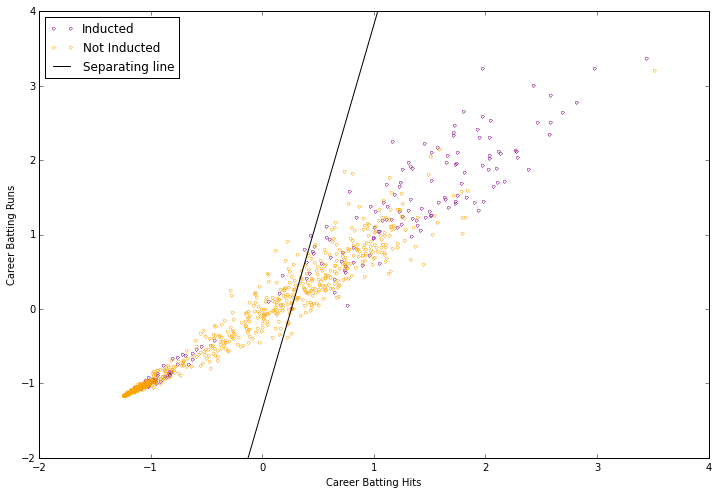

In [67]:
#plot batting hits vs runs with class separation line for training data
bhits_yes = pre2000_exp_scaled.b_hits[pre2000_res == 1]
bhits_no = pre2000_exp_scaled.b_hits[pre2000_res == 0]
bruns_yes = pre2000_exp_scaled.b_runs[pre2000_res == 1]
bruns_no = pre2000_exp_scaled.b_runs[pre2000_res == 0]
plt.figure(figsize = (12, 8))
plt.plot(bhits_yes, bruns_yes, '.', mec = 'purple', mfc = 'None', 
         label = 'Inducted')
plt.plot(bhits_no, bruns_no, '.', mec = 'orange', mfc = 'None', 
         label = 'Not Inducted')
plt.plot(np.arange(-2, 4, 1), intercept + slope * np.arange(-2, 4, 1), '-k', label = 'Separating line')
plt.ylim(-2, 4)
plt.xlabel('Career Batting Hits')
plt.ylabel('Career Batting Runs')
plt.legend(loc = 'best')

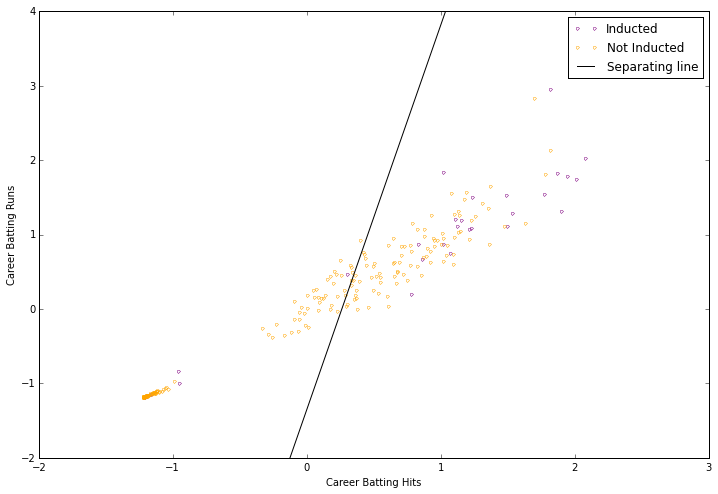

In [68]:
#plot batting hits vs runs with class separation line for test data
post2000_res.index = post2000_exp_scaled.index
bhits_yes = post2000_exp_scaled.b_hits[post2000_res == 1]
bhits_no = post2000_exp_scaled.b_hits[post2000_res == 0]
bruns_yes = post2000_exp_scaled.b_runs[post2000_res == 1]
bruns_no = post2000_exp_scaled.b_runs[post2000_res == 0]
plt.figure(figsize = (12, 8))
plt.plot(bhits_yes, bruns_yes, '.', mec = 'purple', mfc = 'None', 
         label = 'Inducted')
plt.plot(bhits_no, bruns_no, '.', mec = 'orange', mfc = 'None', 
         label = 'Not Inducted')
plt.plot(np.arange(-2, 4, 1), intercept + slope * np.arange(-2, 4, 1), '-k', label = 'Separating line')
plt.ylim(-2, 4)
plt.xlabel('Career Batting Hits')
plt.ylabel('Career Batting Runs')
plt.legend(loc = 'best')